# Kleven Best (2012) Replication

## Solve for the optimal tax schedule

Follow code from hamiltonian_agedep.m

First, import the data from DataPrep.jl (which is from Kleven_Best_Replication_DataPrep.ipynb). This struct has arguments z, n, $\omega_0$, fn, ntop, $\gamma$, $\delta$, $\eta$.

In [12]:
# Load libraries
using Parameters
using Plots
using Trapz
using NumericalIntegration
using SpecialFunctions
using Interpolations
using TimerOutputs

In [11]:
# Add libraries
using Pkg
Pkg.add("TimerOutputs")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [a759f4b9] + TimerOutputs v0.5.21
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
# Import data parameters from from prepare_data.jl
include("DataPrep.jl")
using .DataPrep: prims

In the routine below, the tax schedule is solved in two loops. The outer loop satisfies th government budget constraints by changing the intercepts $T0_y$ and $T0_o$. The inner loop satisfies the optimal tax schedule $T_i(z)$ at age $i \in \{y, o\}$ described in Equation (5):

$$ \frac{\tau_i(z)}{1-\tau_i(z)} = A_i(z)B_i(z)C_i(z)$$

Where:

$$A_i(z) = \left(E_{ii} + E_{ji}\frac{\tau_j(z_j(z))z_j(z)}{\tau_i(z)z}\right)^{-1} $$

$$B_i(z) = \frac{\int_z^\infty [1-g_i(z')]dH_i(z')}{1-H_i(z)} $$

$$C_i(z) = \frac{1-H_i(z)}{zh_i(z)} $$

A few more relevent equations are:

Lifetime utility given by Equation (1):

$$U(z_y, z_o) = z_y - T_y(z_y) - \frac{1}{1+1/e} \left(\frac{z_y}{n}\right)^{1+1/e}\\
+ z_o - T_o(z_o) - \frac{1}{1+1/e} \left(\frac{z_o}{\omega(n, z_y/n)}\right)^{1+1/e}$$

CRRA social welfare function with social welfare weight $g$:

$$\Psi(U) = U^{1-\gamma}/(1-\gamma) $$
$$\implies g = \Psi'(U)/\lambda = U^{-\gamma}/\lambda$$

In [3]:
# First, some helper functions
# Helper function to mimic 'max' in Matlab
function maxdf(dta)
    if size(dta)[1] == 1 # If row vector
        vals, inds = findmax(dta)
        inds = inds[2]
    elseif size(dta)[2] == 1 # If column vector
        vals, inds = findmax(dta)
        inds = inds[1]
    else # If matrix
        vals, inds = findmax(dta, dims = 1)
        inds = getindex.(inds[1,:],1)
    end
    return vals, inds
end;

# Helper function to mimic 'find' in Matlab
function findnon0(dta)
    return findall(!=(0),vec(dta))
end;

# Helper function for linear interpolation
function limat(x, v, endpoint, xq)
    li = LinearInterpolation(x, v, extrapolation_bc = endpoint)
    return li.(xq)
end;

In [13]:
# Function to run the inner loop
function inner_loop(prims, τ_y, τ_o, T0_y, T0_o, λ, SWF, Tax)
    
    @timeit to "Block 1" begin
    # Block 1: Individual optimization
    #println("here1")
    # Pick best combination of zy and zo in terms of lifetime utility
    # Get the tax schedule over z
    # CHECKED/WORKS
    T_yz = cumul_integrate(prims.z, τ_y) .+ T0_y
    T_oz = cumul_integrate(prims.z, τ_o) .+ T0_o

    # Empty vectors for z_i and U
    z_y = zeros(prims.ntop)
    z_o = zeros(prims.ntop)
    Un = zeros(prims.ntop)

    ee = 1 + 1/prims.e

    Threads.@threads for i in 1:prims.ntop # Iterate through the ability distribution
        # Compute lifetime utility from Equation (1)
        y_cons = (1/prims.n[i]^ee)/ee # Last term for y and o
        o_cons = ((1/prims.ω0[i])^ee)/ee
        # Big matrix of utilities for each z_y and z_o
        Ulife = repeat(prims.z', prims.ntop) - repeat(T_yz', prims.ntop) + 
                repeat(prims.z, 1, prims.ntop) - repeat(T_oz, 1, prims.ntop) - 
                repeat(y_cons * ((prims.z').^ee), prims.ntop) - 
                (o_cons * ((prims.z*(1 ./ prims.z.^prims.d)').^ee))
        # Optimize
        U_ozy, zostarzyind = maxdf(Ulife)
        Ustar, zystarind = maxdf(U_ozy)
        # Fill in the vectors
        z_y[i] = prims.z[zystarind]
        z_o[i] = prims.z[zostarzyind[zystarind]]
        Un[i] = Ustar
    end
    end
    
    @timeit to "Block 2" begin
    # Block 2: Right-hand side of the optimality condition
    #println("here2")
    # CHECKED/WORKS
    λ0 = copy(λ)
    λ = trapz(prims.n, Un.^-prims.γ .* prims.fn) # Integral of g(z)dH(z)
    g = (Un.^-prims.γ ./ λ)
    μ = cumul_integrate(prims.n, (g .- 1) .* prims.fn) # Numerator of B
    # BC * 1/(1+e) (the 1-H(z) term cancels out)
    BC = (μ ./ (prims.n .* prims.fn)) .* ee # Divide by denominator of C
    # Find A for the young
    τ_ny = zeros(prims.ntop)
    τ_no = zeros(prims.ntop)
    Threads.@threads for i in 1:prims.ntop
        τ_ny[i] = τ_y[findfirst(prims.z .== z_y[i])]
        τ_no = τ_o[findfirst(prims.z .== z_o[i])]
    end
    A = prims.d .* ((z_o .* (1 .- τ_no)) ./ (z_y .* (1 .- τ_ny)))
    τ_nynew = BC .* (1 .+ (A .* (1 .+ prims.d .- prims.η)))
    # Do I need the missing line?
    τ_nynew = τ_nynew ./ (1 .+ τ_nynew)
    τ_nonew = BC .* (prims.η .- prims.d)
    τ_nonew = τ_nonew ./ (1 .+ τ_nonew)
    end
        
    @timeit to "Block 3" begin
    # Block 3: Tax schedule
    #println("here3")
    # CHECKED/WORKS
    τ_y_new = zeros(prims.ntop)
    τ_o_new = zeros(prims.ntop)
    for i in 1:prims.ntop # Fill in the ones we know
        τ_y_new[findfirst(prims.z .== z_y[i])] = τ_nynew[i]
        τ_o_new[findfirst(prims.z .== z_o[i])] = τ_nonew[i]
    end
    # Interpolate everything else
    # Get the non-zero values
    zfoundinzy = prims.z[findnon0(τ_y_new)]
    τ_yfound = τ_y_new[findnon0(τ_y_new)]
    zfoundinzo = prims.z[findnon0(τ_o_new)]
    τ_ofound = τ_o_new[findnon0(τ_o_new)]
    # Linearly interpolate
    τ_y_new = limat(zfoundinzy, τ_yfound, τ_yfound[1], prims.z)
    τ_o_new = limat(zfoundinzo, τ_ofound, τ_ofound[1], prims.z)
    # Fill in the top values
    topy = findfirst(prims.z .== findmax(z_y)[1])
    for j in topy:prims.ntop
        τ_y_new[j] = τ_nynew[prims.ntop]
    end
    topo = findfirst(prims.z .== findmax(z_o)[1])
    for j in topo:prims.ntop
        τ_o_new[j] = τ_nonew[prims.ntop]
    end
    # Update all the values
    Tax0 = copy(Tax)
    lifetax = z_y + z_o - Un - ((z_y./prims.n).^ee)./ee -
              ((z_o./(prims.ω0 .* (z_y.^prims.d))).^ee)./ee # Check
    Tax = trapz(prims.n, lifetax .* prims.fn)
    SWF0 = copy(SWF)
    SWF = trapz(prims.n, digamma.(Un).*prims.fn)
    #println("here4")
    end
        
    return τ_y_new, τ_o_new, λ0, λ, SWF0, SWF, Tax0, Tax
end

inner_loop (generic function with 1 method)

In [15]:
# Define the main loop
# Variables to iterate over
τ_y = 0.2*ones(prims.ntop)
τ_o = 0.2*ones(prims.ntop)
T0_y = -70000
T0_o = -70000
dTax = 10000
R = 4000 # Revenue requirement
iter1 = 0

# Add timer
to = TimerOutput()

while abs(dTax) > 30
    # Iterators
    iter1 += 1
    iter2 = 0
    # Negative income tax
    T0_y = T0_y - (dTax/2)
    T0_o = T0_o - (dTax/2)
    # Marginal value of public funds
    λ0 = 0
    λ = 1
    # SWF value
    SWF = 1
    SWF0 = 0
    # Tax revenue
    Tax = 1
    Tax0 = 0
    iter2 = 0
    #println("here0")
    
    while abs(λ0 - λ) > 0.000001 ||
    abs(SWF0 - SWF) > 0.0005 ||
    abs(Tax0 - Tax) > 30
        iter2 += 1
        τ_y, τ_o, λ0, λ, SWF0, SWF, Tax0, Tax = 
            inner_loop(prims, τ_y, τ_o, T0_y, T0_o, λ, SWF, Tax)
        println("Inner iter:", iter2, " SWF:", SWF, " Tax:", Tax, " λ:", λ)
        #plot(prims.z, τ_y)
        #plot!(prims.z, τ_o)
    end
    dTax = Tax - R
    println("Outer iter:", iter1, " dTax:", dTax)
end

Inner iter:1 SWF:12.269582665709052 Tax:-121905.49353883721 λ:2.8781285569433857e-53
Inner iter:2 SWF:12.006514634625558 Tax:-84640.36390807912 λ:1.0861630560014676e-52
Inner iter:3 SWF:12.126995704752494 Tax:-95805.8064018106 λ:4.849169124076418e-53
Inner iter:4 SWF:12.041406359734038 Tax:-85178.5758949752 λ:8.748664068855944e-53
Inner iter:5 SWF:12.09209300503961 Tax:-90826.55044920351 λ:6.084810526646116e-53
Inner iter:6 SWF:12.057629348295574 Tax:-86601.13319669748 λ:7.797210960414281e-53
Inner iter:7 SWF:12.079136787906778 Tax:-89148.73851384596 λ:6.66940322758656e-53
Inner iter:8 SWF:12.065031787958167 Tax:-87442.18944180355 λ:7.387511331974711e-53
Inner iter:9 SWF:12.074092122556978 Tax:-88522.57129307951 λ:6.914973896890033e-53
Inner iter:10 SWF:12.068243358946571 Tax:-87790.87378181156 λ:7.21489020666407e-53


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:459[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:467[24m[39m[90m [inlined][39m
      [3] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:474[24m[39m[90m [inlined][39m
      [4] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:829[24m[39m[90m [inlined][39m
      [5] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:828[24m[39m[90m [inlined][39m
      [6] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:212[24m[39m[90m [inlined][39m
      [7] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:211[24m[39m[90m [inlined][39m
      [8] [0m[1mcopy[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:885[24m[39m[90m [inlined][39m
      [9] [0m[1mmaterialize[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:860[24m[39m[90m [inlined][39m
     [10] [0m[1mbroadcast_preserving_zero_d[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:849[24m[39m[90m [inlined][39m
     [11] [0m[1m-[22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m, [90mB[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marraymath.jl:39[24m[39m
     [12] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[13]:25[24m[39m[90m [inlined][39m
     [13] [0m[1m(::var"#117#threadsfor_fun#3"{Main.DataPrep.Prims_struct, Vector{Float64}, Vector{Float64}, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [14] [0m[1m(::var"#117#threadsfor_fun#3"{Main.DataPrep.Prims_struct, Vector{Float64}, Vector{Float64}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [16]:
show(to)

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:       352s /  96.4%           0.97TiB /  97.4%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 Block 1       11     339s  100.0%   30.8s   0.94TiB  100.0%  87.6GiB
 Block 3       10   36.9ms    0.0%  3.69ms   89.4MiB    0.0%  8.94MiB
 Block 2       10   33.8ms    0.0%  3.38ms   88.5MiB    0.0%  8.85MiB
 ────────────────────────────────────────────────────────────────────

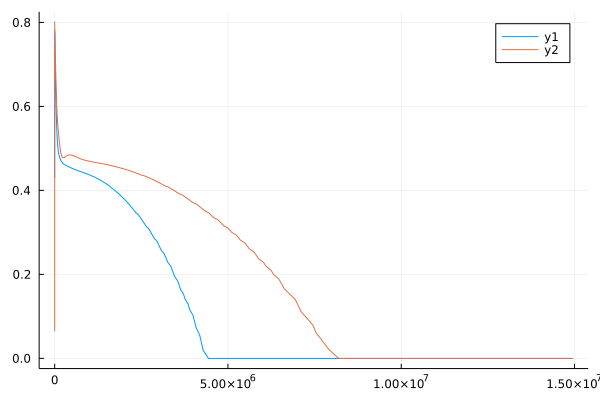

In [6]:
# Check (intermediate) results
plot(prims.z, τ_y)
plot!(prims.z, τ_o)